In [1]:
import os
import requests
from requests_oauthlib import OAuth1
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from collections import Counter
import json

### Function for getting the last tweets from a user screen name

In [2]:
def get_tweets_from_screen_name(screen_name, max_tweets=100):

    """
    Retrieve the last n tweets (including retweets) for a given user
    (max n = 3200)
    """
    params = {
        "screen_name": screen_name,
        "count": max_tweets,
        "include_rts": "true",
        "exclude_replies": "false",
        "tweet_mode": "extended"
    }
    # A cursor in instanciated in order to navigate into the tweets
    cursor = None
    tweets=[]
    while len(tweets) < max_tweets:
        if cursor is not None:
            params["max_id"] = cursor
            start_index = 1
        else:
            start_index = 0
        
        # Start index allows to ignore the first result when it has already been extracted (cf param "max_id" in Twitter API)
        r = requests.get("https://api.twitter.com/1.1/statuses/user_timeline.json", params=params, auth=auth, timeout=5)
        if r.status_code != 200:
            print(r.text)
            return tweets

        try:
            results = r.json()[start_index:]
        except:
            return tweets

        if len(results) > 0:
            for result in results:
                tweets.append(result)
                if len(tweets) == max_tweets:
                    return tweets
            cursor = results[-1]["id"]
        else:
            return tweets
    return tweets


### Functions that get all the accounts related to one tweet

In [3]:
def get_accounts_from_tweet(tweet):
    accounts = []
    if tweet["in_reply_to_screen_name"] != None:
        accounts.append(tweet["in_reply_to_screen_name"])
    for account in tweet["entities"]["user_mentions"]:
        accounts.append(account["screen_name"])
    if tweet.get("retweeted_status") != None:
        accounts.append(tweet["retweeted_status"]["user"]["screen_name"])
        for account in tweet["retweeted_status"]["entities"]["user_mentions"]:
            accounts.append(account["screen_name"])
    return list(set(accounts))

### Get the tweets and compute all the pairs of mentions

In [4]:
twitter_screen_name = "MR_officiel"
max_tweets=3200

In [5]:
credentials = json.load(open("credentials.json", "r"))
auth = OAuth1(credentials["consumer_key"], credentials["consumer_secret"], credentials["access_token"], credentials["access_token_secret"])

pairs = []
for tweet in get_tweets_from_screen_name(twitter_screen_name, max_tweets):
    accounts = get_accounts_from_tweet(tweet)
    for pair in combinations(accounts, 2):
        if twitter_screen_name not in pair:
            pairs.append(tuple(sorted(pair)))

### Create the Graph based on the pairs and the weight

In [6]:
# Create the graph
G = nx.Graph()
for pair, count in Counter(pairs).items():
    if count > 3:
        G.add_edge(pair[0], pair[1], weight=count)

degrees = dict(G.degree)



### Apply Louvain algorithm and create the layout of the graph

In [9]:
# compute the best partition
partition = community_louvain.best_partition(G)
pos = nx.spring_layout(G, iterations=int(len(pairs) / 100))

### Generate the final graph based on the results of the Louvain algorithm

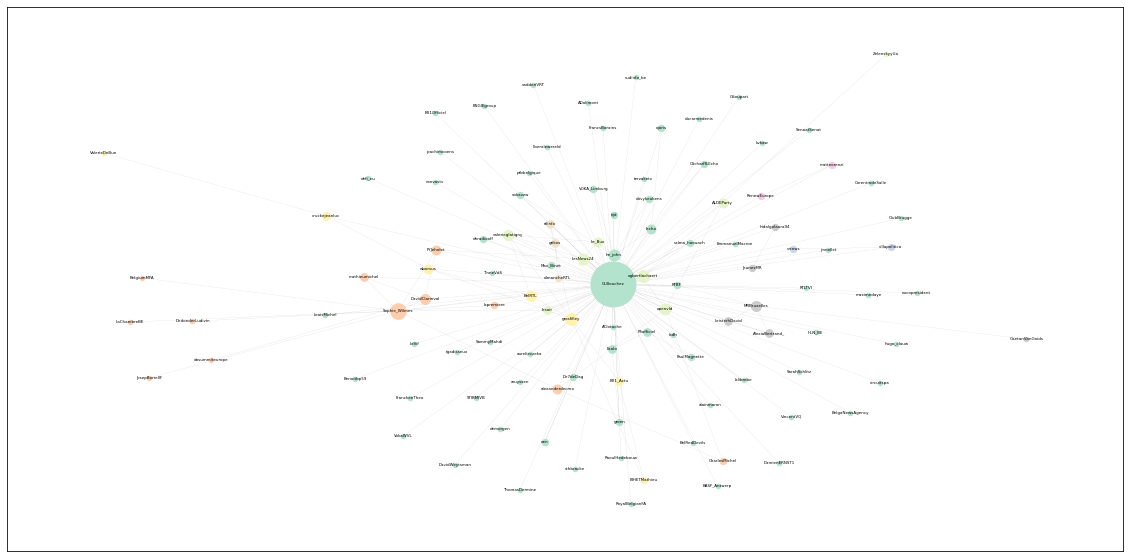

In [10]:

plt.figure(figsize=(20,10))
# color the nodes according to their partition
cmap = cm.get_cmap('Pastel2', max(partition.values()) + 1)
nx.draw_networkx_edges(G, pos, alpha=0.5, style='dashed', width=0.1)
nx.draw_networkx_labels(G, pos, font_size=4, font_color="black")
for node, color in partition.items():
    nx.draw_networkx_nodes(G, pos, [node], node_size=degrees[node]*20, node_color=[cmap.colors[color]])
    
plt.savefig("twitter_screen_name.png", dpi=300)
    